Building Regularized Logistic Rgression

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
from sklearn import preprocessing
import pickle
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
#Load the data 
with open('test_set.pkl', 'rb') as f:
        X_test= pickle.load(f)  
with open('train_set.pkl', 'rb') as f:
        X_train= pickle.load(f)  
with open('ytest.pkl', 'rb') as f:
        y_test= pickle.load(f)  
with open('ytrain.pkl', 'rb') as f:
        y_train= pickle.load(f)  
for i in [X_train,X_test]:
    i.pop("artist_has_award")


In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train['top10'])

In [20]:
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 
print("Number transactions X_train dataset: ", X_train_sm.shape) 
print("Number transactions y_train dataset: ", y_train_sm.shape) 

Number transactions X_train dataset:  (6287, 26)
Number transactions y_train dataset:  (6287, 1)
Number transactions X_test dataset:  (1602, 26)
Number transactions y_test dataset:  (1602, 1)
Number transactions X_train dataset:  (10940, 26)
Number transactions y_train dataset:  (10940,)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy of logistic regression classifier on test set: 0.68


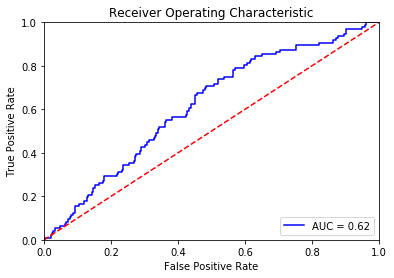

In [22]:
import sklearn.metrics as metrics

a = logreg.predict_proba(X_test)
lr_probs = a[:,1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

fpr, tpr, threshold = metrics.roc_curve(y_test, lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("Logisticregression")
plt.show()


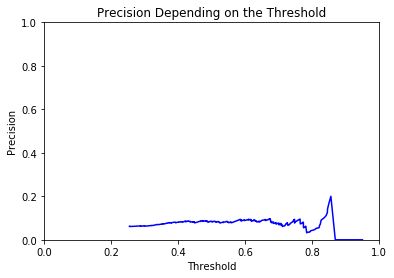

In [23]:
 #Precision over threshold
from sklearn.metrics import precision_recall_curve
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,lr_probs)
# calculate precision-recall AUC
precision_auc = metrics.auc(recall, precision)

plt.title('Precision Depending on the Threshold')
plt.plot(thresholds, precision[:len(precision)-1], 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Threshold')
plt.savefig("PrecisionLogistic")
plt.show()

In [29]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

predictions_matrix = [1 if pred > 0.65 else 0 for pred in lr_probs]
confusion_matrix(y_test,predictions_matrix)

array([[1343,  163],
       [  80,   16]], dtype=int64)

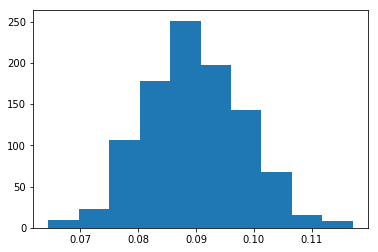

95.0 confidence interval 7.4% and 10.6%


In [26]:
#Boostrapping the precision 
from sklearn.utils import resample
df = X_test.copy()
df["top10"] = y_test.values
stats = list()
for i in range(1000):
    boot = resample(df, replace=True, n_samples=10000)
    boot_y = boot.pop("top10")
    boot_pred = logreg.predict_proba(boot)[:,1]
    predictions_matrix = [1 if pred > 0.65 else 0 for pred in boot_pred]
    precision = (confusion_matrix(boot_y,predictions_matrix)[1][1]) / (confusion_matrix(boot_y,predictions_matrix)[1][1] + confusion_matrix(boot_y,predictions_matrix)[0][1]) 
    stats.append(precision)
    
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))